In [75]:
import sys, os
DMOL_DIR = "/Users/Henryye/research/shaf/DMOL"
sys.path.append(os.path.join(DMOL_DIR, "utils"))

#from ml_utlis import *
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/CalebPitts/Documents/Files/School/College/19-20-Year/Research/DMOL/utils')
from ml_utils import *
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.decomposition import PCA, KernelPCA


import warnings
warnings.filterwarnings('ignore')

In [3]:
df_proc = pd.read_csv("/Users/CalebPitts/Documents/Files/School/College/19-20-Year/Research/data/proc_df.csv")
var_map = pickle.load(open("/Users/CalebPitts/Documents/Files/School/College/19-20-Year/Research/data/var_map.pkl", 'rb'))

In [59]:
def produce_nonlinear_pca(scree_data, df, var_map_curr, kernel, week_num, n_comp=5):
    X = pd.DataFrame()
    target = ""
    
    pca = KernelPCA(n_components=n_comp, kernel=kernel, degree=3)
    for construct in var_map_curr["Quant"]:
        temp = df[list(var_map_curr["Quant"][construct])].copy()
        temp = temp.fillna(temp.mode().iloc[0])
        #if len(var_map_curr["Quant"][construct]) < n_comp:
        #    X = pd.concat([X, temp.copy()], axis = 1)
        if True:
            temp_pca = pd.DataFrame(pca.fit_transform(temp))
            temp_pca.columns = ["{}_PC{}".format(construct, i) for i in range(1, n_comp+1)]
            X = pd.concat([X, temp_pca], axis = 1)
            
            explained_variance = np.var(temp_pca, axis=0)
            explained_variance_ratio = explained_variance / np.sum(explained_variance)
            scree_row = {"Target Week": week_num, "Construct": construct, "Kernel": kernel}
            for i, comp_var in enumerate(explained_variance_ratio):
                scree_row["Component " + str(i+1)] = round(comp_var, 5)
            
            scree_data.append(scree_row)
    
    return X, scree_data

In [60]:
def standardize_X(X):
    X_vals = X.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_vals_scaled = min_max_scaler.fit_transform(X_vals)
    X = pd.DataFrame(x_vals_scaled)
    
    return X

In [101]:
def classify_response(X, y):
    halves = []
    for val in y:
        if val in [1,2]:
            halves.append(1)
        else:
            halves.append(2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, halves, test_size = 0.3, random_state = 42)
    
    accs = []
    for n in range(3, 15):
        #print("\nN Estimators:", n)
        mod = RandomForestClassifier(n_estimators=n, max_depth=None).fit(X_train, y_train)
    
        y_train_pred = mod.predict(X_train)
        #print("Training Accuracy: {}".format(accuracy_score(y_train, y_train_pred)))

        y_test_pred = mod.predict(X_test)
        #print("Testing  Accuracy: {}".format(accuracy_score(y_test, y_test_pred)))
        accs.append((accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))
        
    return accs

In [102]:
def get_scree_threshold(scree_data):
    scree_df = pd.DataFrame(scree_data)
    thresholds_broken = []
    for i in range(len(scree_df)):
        var_tot = 0
        passed = False
        for index in scree_df.iloc[i].index:
            if index.startswith("Component "):
                var_tot += scree_df.iloc[i][index]
                if var_tot > .90 and not passed:
                    passed = True
                    thresholds_broken.append(int(index.split()[1]))
        if not passed:
            thresholds_broken.append(-1)
    
    scree_df["Cum_90_Components"] = thresholds_broken
    
    return scree_df

In [129]:
def group_accs(all_accs):
    grouped_training_accs = []
    grouped_testing_accs = []
    for n in range(0, 12):  #iterate over n estimators
        training_accs_group = []
        testing_accs_group = []
        for accs in all_accs:
            training_accs_group.append(accs[n][0])
            testing_accs_group.append(accs[n][1])
        grouped_training_accs.append(sum(training_accs_group)/len(training_accs_group))
        grouped_testing_accs.append(sum(testing_accs_group)/len(testing_accs_group))
        
    return grouped_training_accs, grouped_testing_accs

In [144]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7

In [145]:
def plot_scree_bars(scree_df, kernel):
    plt.bar(scree_df["Cum_90_Components"].value_counts().index, scree_df["Cum_90_Components"].value_counts().values)
    plt.title("# PC needed to achieve >90% Variance Captured Construct: {}".format(kernel))
    plt.xlabel("Number of Princinple Components")
    plt.ylabel("Number of Constructs")
    plt.show()

In [146]:
def plot_rf_n_estimators(grouped_training_accs, grouped_testing_accs, kernel):
    plt.plot(grouped_training_accs, label="training", marker='o', color='r')
    plt.plot(grouped_testing_accs, label="testing", marker='o', color='b')
    plt.title("Accuracy By # of Estimators: {}".format(kernel))
    plt.xlabel("N Estimators")
    plt.ylabel("Classification Accuracy")
    plt.legend()
    plt.show()

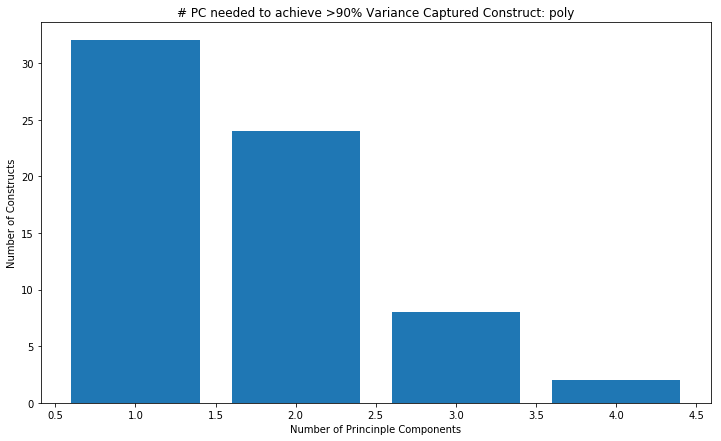

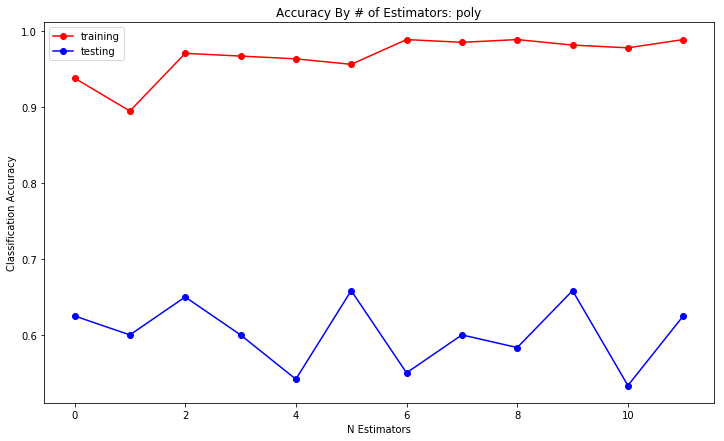

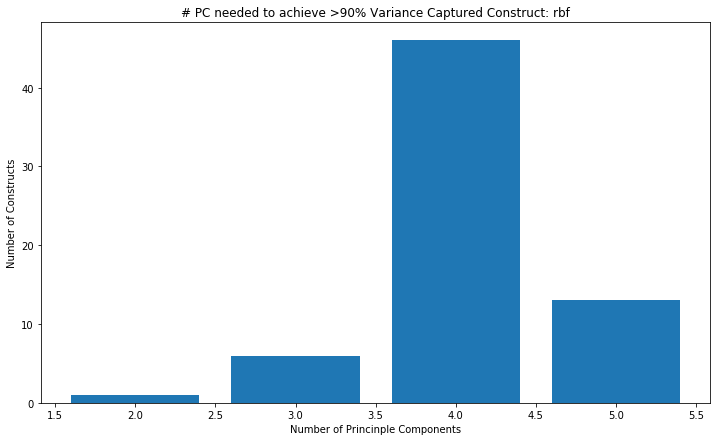

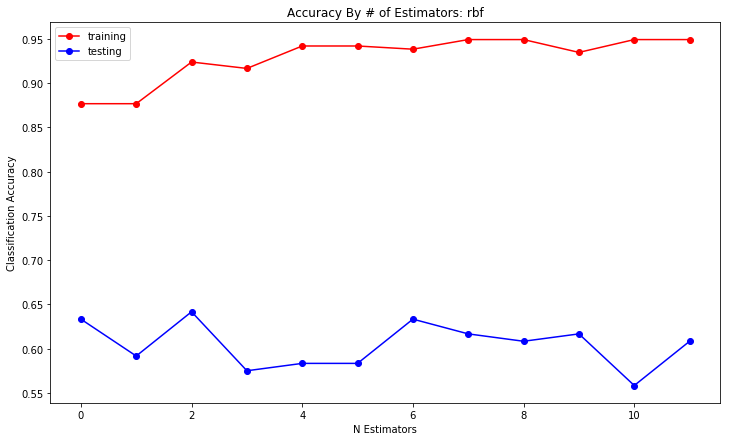

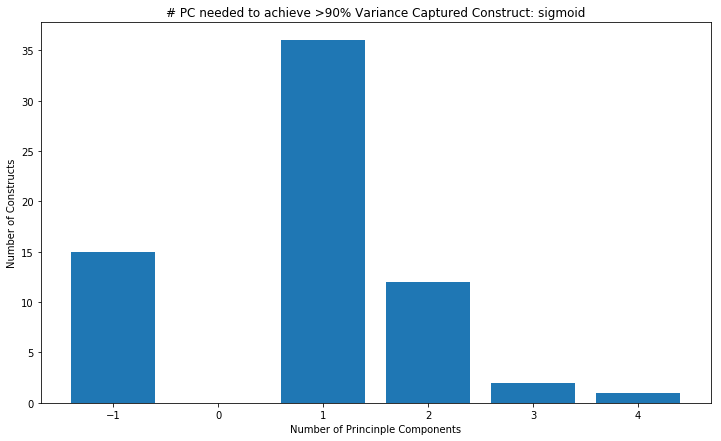

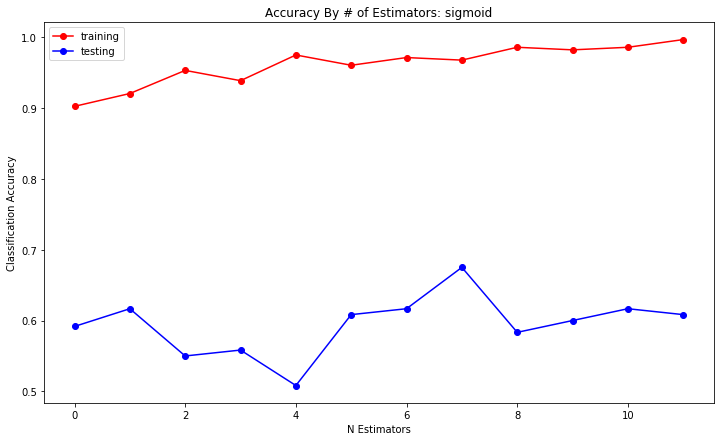

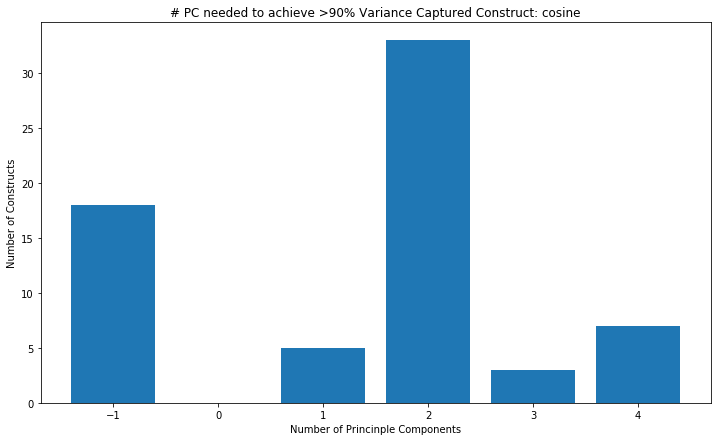

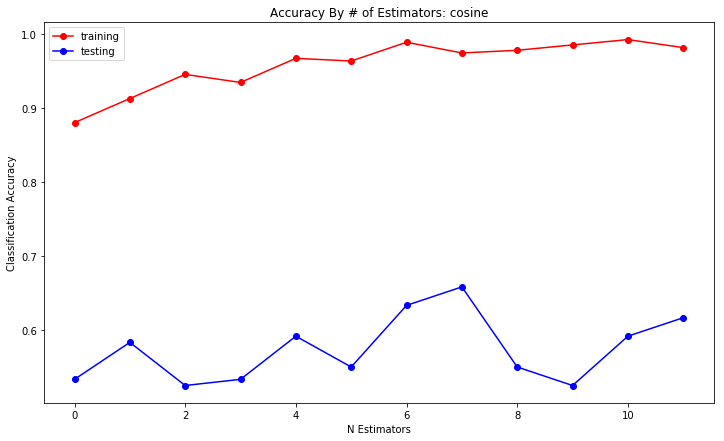

In [147]:
for kernel in ['poly', 'rbf', 'sigmoid', 'cosine']:
    scree_data = []
    all_accs = []
    for week_num in range(1, 5):
        #print("\n\nWeek {}:".format(week_num))
        var_map_curr = NEW_VAR_MAP["week_{}".format(week_num)]
        X, scree_data = produce_nonlinear_pca(scree_data, df_proc, var_map_curr, kernel, week_num)
        scree_df = get_scree_threshold(scree_data)
        
        X = standardize_X(X)
        y = df_proc["gr_revq{}_quantile".format(week_num)]
           
        all_accs.append(classify_response(X, y))
    
    grouped_training_accs, grouped_testing_accs = group_accs(all_accs)
    plot_scree_bars(scree_df, kernel)
    plot_rf_n_estimators(grouped_training_accs, grouped_testing_accs, kernel)

In [32]:
def train_model(df, week_num, n_comp = None, use_fr = False, plot = False, verbose = False):
    
    def construct_X(df, week_num, var_map_curr, n_comp = None, verbose = False):
        X = pd.DataFrame()
        target = ""
        pca = KernelPCA(n_components=n_comp, kernel='poly', degree=3) if n_comp is not None else None
        
        for construct in var_map_curr["Quant"]:
            temp = df[list(var_map_curr["Quant"][construct])].copy()
            temp = temp.fillna(temp.mode().iloc[0])
            if n_comp is None:
                temp_mean = pd.DataFrame(temp.mean(axis=1))
                temp_mean.columns = ["{}_mean".format(construct)]
                X = pd.concat([X, temp_mean], axis = 1)
            else:
                #if len(var_map_curr["Quant"][construct]) < n_comp:
                #    X = pd.concat([X, temp.copy()], axis = 1)
                if True: #else:
                    temp_pca = pd.DataFrame(pca.fit_transform(temp))
#                     explained_variance = np.var(temp_pca, axis=0)
#                     explained_variance_ratio = explained_variance / np.sum(explained_variance)

#                     scree_row = {"Target Week": week_num, "Construct": construct, "Kernel": "cosine"}
#                     for i, comp_var in enumerate(explained_variance_ratio):
#                         scree_row["Component " + str(i+1)] = round(comp_var, 5)
                    
#                     SCREE_DATA.append(scree_row)
                    
                    temp_pca.columns = ["{}_PC{}".format(construct, i) for i in range(1, n_comp+1)]
                    X = pd.concat([X, temp_pca], axis = 1)
                    if verbose:
                        print("{} variance explained:\n{}\n".format(construct, pca.explained_variance_ratio_))
        return X
    
    var_map_curr = NEW_VAR_MAP["week_{}".format(week_num)]
    X, y = construct_X(df, week_num, var_map_curr, n_comp, verbose), df["gr_revq{}_quantile".format(week_num)]
    
    for gr in ["gr_revq{}".format(i) for i in range(max(1, week_num-1), week_num)]:
        X[gr] = df[gr]
    
    
    # Standardization
    X_vals = X.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_vals_scaled = min_max_scaler.fit_transform(X_vals)
    X = pd.DataFrame(x_vals_scaled)
    
    # Get bottom and top halves
    halves = []
    for val in y:
        if val in [1,2]:
            halves.append(1)
        else:
            halves.append(2)
    
    pd.Series(halves)
        
    ### Classification Modeling ###
    X_train, X_test, y_train, y_test = train_test_split(X, halves, test_size = 0.3, random_state = 42)
    
    for n in range(3, 9):
        print("\nN Estimators:", n)
        mod = RandomForestClassifier(n_estimators=n, max_depth=None).fit(X_train, y_train)
    
        y_train_pred = mod.predict(X_train)
        print("Training Accuracy: {}".format(accuracy_score(y_train, y_train_pred)))

        y_test_pred = mod.predict(X_test)
        print("Testing  Accuracy: {}".format(accuracy_score(y_test, y_test_pred)))


In [33]:
for week_num in range(1, 6):
    print("Week {}".format(week_num))
    X = train_model(df_proc, week_num, n_comp=2, use_fr = False, plot = False)
    print('\n\n')

Week 1

N Estimators: 3
Training Accuracy: 0.855072463768116
Testing  Accuracy: 0.43333333333333335

N Estimators: 4
Training Accuracy: 0.8985507246376812
Testing  Accuracy: 0.6

N Estimators: 5
Training Accuracy: 0.9420289855072463
Testing  Accuracy: 0.6

N Estimators: 6
Training Accuracy: 0.9710144927536232
Testing  Accuracy: 0.5666666666666667

N Estimators: 7
Training Accuracy: 0.9855072463768116
Testing  Accuracy: 0.5666666666666667

N Estimators: 8
Training Accuracy: 0.9565217391304348
Testing  Accuracy: 0.5333333333333333



Week 2

N Estimators: 3
Training Accuracy: 0.927536231884058
Testing  Accuracy: 0.6666666666666666

N Estimators: 4
Training Accuracy: 0.8405797101449275
Testing  Accuracy: 0.7666666666666667

N Estimators: 5
Training Accuracy: 0.927536231884058
Testing  Accuracy: 0.6666666666666666

N Estimators: 6
Training Accuracy: 0.9710144927536232
Testing  Accuracy: 0.7

N Estimators: 7
Training Accuracy: 0.9710144927536232
Testing  Accuracy: 0.5666666666666667

N Esti

In [130]:
scree_df = pd.DataFrame(SCREE_DATA)

In [116]:
thresholds_broken = []
for i in range(len(scree_df)):
    var_tot = 0
    passed = False
    for index in scree_df.iloc[i].index:
        if index.startswith("Component "):
            var_tot += scree_df.iloc[i][index]
            if var_tot > .90 and not passed:
                passed = True
                thresholds_broken.append(int(index.split()[1]))
    if not passed:
        thresholds_broken.append(-1)

In [117]:
scree_df["Cum_90_Components"] = thresholds_broken

In [121]:
clean_scree = scree_df[["Kernel", "Construct", "Target Week", "Cum_90_Components", "Component 1", "Component 2", "Component 3", "Component 4", "Component 5"]]

In [125]:
for kernel in clean_scree["Kernel"].unique():
    print(kernel)
    print(clean_scree[clean_scree["Kernel"] == kernel]["Cum_90_Components"].value_counts())
    print()

poly
1    42
2    27
3    10
4     2
Name: Cum_90_Components, dtype: int64

rbf
4    59
5    13
3     8
2     1
Name: Cum_90_Components, dtype: int64

sigmoid
 1    45
-1    19
 2    14
 3     2
 4     1
Name: Cum_90_Components, dtype: int64

cosine
 2    42
-1    23
 4     8
 1     5
 3     3
Name: Cum_90_Components, dtype: int64



In [128]:
clean_scree.to_csv("/Users/CalebPitts/Documents/Files/School/College/19-20-Year/Research/DMOL/data/clean_scree.csv")